---
title: Forecasting Video Game Speedrunning
description: none
date: 7/15/2022
draft: false
bibliography: references.bib
csl: annals_statistics.csl
format:
  html:
    code-fold: false
    page-layout: full
---

I was recently challenged by [Jaime Sevilla](https://twitter.com/Jsevillamol?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) to try out our experimental package [`fmax`](https://github.com/jlindbloom/fmax)^[`fmax` is a tool for forecasting the time series of a cumulative maximum/minimum, given data on the historical cumulative maximum/minimum. This post uses [`v0.0.1`](https://github.com/jlindbloom/fmax/tree/v0.0.1).] on the problem of forecasting video game speedrunning records. In this post, we will:

- gather some data on video game speedrunning records,
- use fmax to generate forecasts of the records moving forward,
- and compare the performance of fmax with baseline forecasting methods.

Here I will not go into the details behind the forecasting methodology used by `fmax`, as they can be found into two of our previous articles [here](https://www.authorea.com/users/429500/articles/535592-a-bayesian-model-of-records) and [here](https://www.authorea.com/users/429500/articles/533177-modelling-a-time-series-of-records-with-pymc3).

# Collecting the Data

Below is some code (credits to [Jaime Sevilla](https://twitter.com/Jsevillamol?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor)) for scraping the website [https://www.speedrun.com](https://www.speedrun.com) for data on the most popular video games on the site for which speedruns are attempted. For each game, we scrape data for each run and assemble all of the results into a `pandas.DataFrame`.

In [1]:
#@title Download data
import urllib.request
import urllib.error
from urllib.parse import quote
import re
import ast
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

fresh_download = False #@param {'type':'boolean'}
if fresh_download:
  # Get most popular speedrunning games
  N_GAMES = 100 #@param
  most_popular_games = []
  for step in range(0, N_GAMES, 50):
    ajax_request = f'https://www.speedrun.com/ajax_games.php?unofficial=off&orderby=mostruns&start={step}'
    response = urllib.request.urlopen(ajax_request)
    soup = BeautifulSoup(response, 'html.parser')
    most_popular_games += [link.get('href') for link in soup.find_all('a') if link.get('href') is not None]

  # Iterate over all WR progression of more popular games and store new world record run information
  data = []
  for game_id in tqdm(most_popular_games):

    # Retrive name of game
    game_url = f"https://www.speedrun.com/{game_id}"
    try:
      response = urllib.request.urlopen(game_url)
    except urllib.error.HTTPError:
      print(f"ERROR: Could not access {game_url}")
      continue
    soup = BeautifulSoup(response, 'html.parser')
    game_title = re.match(r'(.*) - speedrun.com', soup.title.string).group(1)

    print(f"Downloading data for {game_title}")

    # Retrive stats page of game
    game_stats_url = f"https://www.speedrun.com/{game_id}/gamestats"
    try:
      response = urllib.request.urlopen(game_stats_url)
    except urllib.error.HTTPError:
      print(f"ERROR: Could not access {game_stats_url}")
      continue
    page_source = response.read().decode('utf-8')

    # Extract data about WR progression
    m = re.search(r'var runs = (.*);', page_source).group(1)
    m = m.replace("true", "True")
    m = m.replace("false", "False")
    d = ast.literal_eval(m)
    
    if type(d) is dict:
      full_game_data = d['0'] # The '0' key is the full game data
                              # The rest are individual levels  
    else: # Only the full game data is available    
      full_game_data = d[0]

    for category in full_game_data:
      category_label = category['label']
      #print(f"Downloading data for {game_title} - {category_label}")
      for run in category['data']:
        run_link = run['link']
        run_url = 'https://www.speedrun.com' + run_link.replace('\\', '')
        time = run['y']
        date = run['x'] # gmtime(run['x'])
        runners = ', '.join(run['players'])

        # Add entry to dataset
        entry = {
            "game" : game_title,
            "category" : category_label,
            "time (seconds)" : time,
            "date (unix)" : date,
            "runner" : runners,
            "url" : run_url,
        }
        data.append(entry)

  df = pd.DataFrame(data)

  # Recode columns
  df['date'] = pd.to_datetime(df['date (unix)'],unit='s')

  # Select runs from categories where the record has been improved at least 10 times
  RUN_THRESHOLD = 50 #@param
  group_mask = df.groupby(['game', 'category']).size()>=RUN_THRESHOLD
  mask = df.apply(lambda row : group_mask[row['game'], row['category']], axis=1)
  df = df[mask]

  # Reset index
  df = df.reset_index()

  # Save to CSV
  df.to_csv('WR_improvements.csv')

else: # Load from sheet
  URL = "https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

  url = URL.format(
      sheet_id = '19tD0nAN0Z_2vKspGsk-v1pgxns0u1Z7s5Klp5ManMVE',
      sheet_name = quote('01/07/2022 (100 games, >50 WR)'))

  df = pd.read_csv(url, index_col=0)

  # Recode columns
  df['date'] = pd.to_datetime(df['date (unix)'],unit='s')

# Print dataset information
n_games = len(df.groupby('game'))
n_categories = len(df.groupby(['game', 'category']))
n_runs = len(df)
print(f"There are {n_games} games, {n_categories} categories and {n_runs} runs")

# Do some preprocessing

## Combine game and category
df["Game - Category"] = df.apply(lambda row : row['game'] + " - " + row['category'], axis=1)

## Compute relative improvements
mask = df.groupby(['Game - Category'])['date'].idxmin()
assert len(mask) == n_categories
first_run_time_per_category = {row['Game - Category'] : row['time (seconds)'] 
                               for index, row in df.loc[mask.values].iterrows()}
first_run_times = df.apply(lambda row : first_run_time_per_category[row['Game - Category']], axis=1)
df["relative improvement"] = first_run_times / df['time (seconds)']

## Compute relative times
mask = df.groupby(['Game - Category'])['date'].idxmax()
assert len(mask) == n_categories
last_run_time_per_category = {row['Game - Category'] : row['time (seconds)'] 
                               for index, row in df.loc[mask.values].iterrows()}
last_run_times = df.apply(lambda row : last_run_time_per_category[row['Game - Category']], axis=1)
df["relative time"] = (df['time (seconds)'] - last_run_times) / (first_run_times - last_run_times)

## Compute days since first run
mask = df.groupby(['Game - Category'])['date'].idxmin()
assert len(mask) == n_categories
first_run_date_per_category = {row['Game - Category'] : row['date'] 
                               for index, row in df.loc[mask.values].iterrows()}
first_run_dates = df.apply(lambda row : first_run_date_per_category[row['Game - Category']], axis=1)
df["days since first run"] = (df['date'] - first_run_dates).map(lambda dt : dt.days)

# Compute relative days overall
mask = df.groupby(['Game - Category'])['date'].idxmax()
assert len(mask) == n_categories
last_run_date_per_category = {row['Game - Category'] : row['date'] 
                               for index, row in df.loc[mask.values].iterrows()}
last_run_dates = df.apply(lambda row : last_run_date_per_category[row['Game - Category']], axis=1)
df["relative days since first run"] = (df['date'] - first_run_dates).map(lambda dt : dt.days) / \
                                      (last_run_dates - first_run_dates).map(lambda dt : dt.days)

# Compute category index
df['WR index'] = df.groupby(['Game - Category']).cumcount()

# Compute relative category index
category_WR_counts = df.groupby(['Game - Category'])['WR index'].max()
df['relative WR index'] = df.apply(lambda row : row['WR index'] / category_WR_counts[row['Game - Category']], axis=1)

## Add empirical first order differences
df['time (seconds) diff'] = df.groupby(['game', 'category'])['time (seconds)'].diff().fillna(0.)
assert (df['time (seconds) diff'] <= 0.).all()
df['relative improvement diff'] = df.groupby(['game', 'category'])['relative improvement'].diff().fillna(0.)
assert (df['relative improvement diff'] >= 0.).all()
df['relative time diff'] = df.groupby(['game', 'category'])['relative time'].diff().fillna(0.)
assert (df['relative time diff'] <= 0.).all()

There are 17 games, 25 categories and 1688 runs


Let's look at the format of our dataset.

In [2]:
df.head(5)

,index,game,category,time (seconds),date (unix),runner,url,date,Game - Category,relative improvement,relative time,days since first run,relative days since first run,WR index,relative WR index,time (seconds) diff,relative improvement diff,relative time diff
0,0,Super Mario 64,120 Star - N64,7840.0,1158235200,Dragorn,https://www.speedrun.com/sm64/run/9786,2006-09-14 12:00:00,Super Mario 64 - 120 Star - N64,1.000000,1.000000,0,0.000000,0,0.000000,0.0,0.000000,0.000000
1,1,Super Mario 64,120 Star - N64,7660.0,1279108800,[jp]ショウ (Shō),https://www.speedrun.com/sm64/run/9780,2010-07-14 12:00:00,Super Mario 64 - 120 Star - N64,1.023499,0.908629,1399,0.247786,1,0.019231,-180.0,0.023499,-0.091371
2,2,Super Mario 64,120 Star - N64,6760.0,1293883200,[jp]シゲル (Shigeru),https://www.speedrun.com/sm64/run/9735,2011-01-01 12:00:00,Super Mario 64 - 120 Star - N64,1.159763,0.451777,1570,0.278073,2,0.038462,-900.0,0.136265,-0.456853
3,3,Super Mario 64,120 Star - N64,6589.0,1305720000,[jp]えるも (Erumo),https://www.speedrun.com/sm64/run/320637,2011-05-18 12:00:00,Super Mario 64 - 120 Star - N64,1.189862,0.364975,1707,0.302338,3,0.057692,-171.0,0.030099,-0.086802
4,4,Super Mario 64,120 Star - N64,6530.0,1317470400,[jp]はちみつ (Honey),https://www.speedrun.com/sm64/run/3243556,2011-10-01 12:00:00,Super Mario 64 - 120 Star - N64,1.200613,0.335025,1843,0.326426,4,0.076923,-59.0,0.010751,-0.029949


In [3]:
# Print a list of the games
df['Game - Category'].unique()

array(['Super Mario 64 - 120 Star - N64',
       'Super Mario Odyssey - Any% - 1P',
       'Super Mario Odyssey - World Peace',
       'Super Mario Odyssey - Darker Side', 'Celeste - Any%',
       'Celeste - All Red Berries', 'Portal - Out of Bounds - PC',
       'Getting Over It With Bennett Foddy - Glitchless',
       'Super Metroid - Any%', 'Super Mario Sunshine - Any% - GCN',
       'SpongeBob SquarePants: Battle for Bikini Bottom - Any%',
       'SpongeBob SquarePants: Battle for Bikini Bottom - 100%',
       'Outlast - Any% - Main Game, PC',
       'Hollow Knight - Any% - No Major Glitches',
       'Refunct - Any% - Normal', 'Undertale - Neutral - 1.00-1.001',
       'Undertale - True Pacifist - 1.00-1.001',
       'The Legend of Zelda: Breath of the Wild - Any%',
       'The Legend of Zelda: Breath of the Wild - All Shrines - Original, No Restrictions',
       'The Legend of Zelda: Breath of the Wild - All Dungeons - Original',
       'Grand Theft Auto V - Any% - Classic',
     

# A Visualization

Let's plot some of the data we just collected.

In [4]:
# Visualize the data
# Credits to Jaime Sevilla

x_axis = 'days since first run' #@param ['date', 'days since first run', 'relative days since first run', 'WR index', 'relative WR index']
y_axis = 'time (seconds)' #@param ['time (seconds)', 'time (seconds) diff', 'relative improvement', 'relative improvement diff', 'relative time','relative time diff']
x_scale = 'log' #@param ['linear', 'log']
y_scale = 'linear' #@param ['linear', 'log']
mark_type = 'point' #@param ['line', 'point']

import altair as alt

alt.themes.enable('fivethirtyeight')
alt.data_transformers.disable_max_rows()

game_cat_dropdown = alt.binding_select(options=df["Game - Category"].unique())
game_cat_select = alt.selection_single(
                     fields=['Game - Category'], 
                     bind= game_cat_dropdown, 
                     name="Game - Category")

chart = alt.Chart(df, 
    width=400, 
    height=600
).encode(
    x=alt.X(f'{x_axis}', scale=alt.Scale(type=x_scale)),
    y=alt.Y(f'{y_axis}:Q', scale=alt.Scale(type=y_scale)),
    color='Game - Category:N',
    tooltip=[
             'date:T',
             'time (seconds):Q',
             'Game - Category:N',
             'runner',
             'url'
             ]
).add_selection(
    game_cat_select
).transform_filter(
    game_cat_select
).configure_axis(
    labelFontSize=20,
    titleFontSize=30
).configure_legend(
    titleFontSize=20,
    labelFontSize =18,
    gradientLength=400,
    gradientThickness=30,
    symbolSize = 130,
).configure_legend(labelLimit= 0)\
.interactive()

if mark_type == 'line':
  chart = chart.mark_line()
else: # if mark_type == 'point'
  chart = chart.mark_point()

if x_scale == 'log':
  chart = chart.transform_filter(
    alt.FieldGTPredicate(x_axis, 0.)
  )

if y_scale == 'log':
  chart = chart.transform_filter(
    alt.FieldGTPredicate(y_axis, 0.)
  )

chart

alt.Chart(...)

That chart has a lot of data on it (and may not render properly on your device), so let's also just look at a single game.

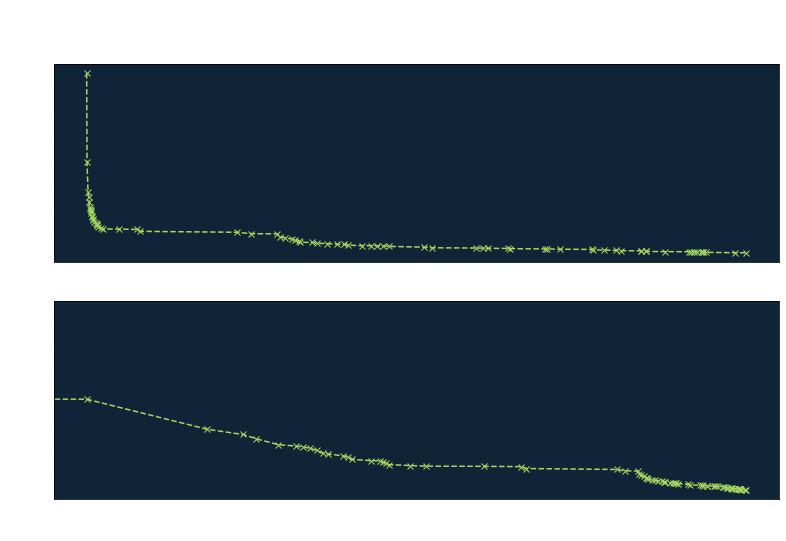

In [5]:
#| label: fig-botw_any_per
#| fig-cap: Speedrunning data for The Legend of Zelda, Breath of the Wild (Any %).

import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = '#0F2537'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Get the subset for a game
which_game = "The Legend of Zelda: Breath of the Wild - Any%"
game_df = df[df["Game - Category"] == which_game]
game_df.head()

# Make the plot
fig, axs = plt.subplots(2,1, figsize=(13,8))

axs[0].plot(game_df["date"], game_df["time (seconds)"], "x--", color="#A5D75E")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Time (seconds)")

axs[1].plot(game_df["days since first run"], game_df["time (seconds)"], "x--", color="#A5D75E")
axs[1].set_xlabel("Days since first run (log-scale)")
axs[1].set_ylabel("Time (seconds)")
axs[1].set_xscale("log")

fig.suptitle(which_game)

plt.show()

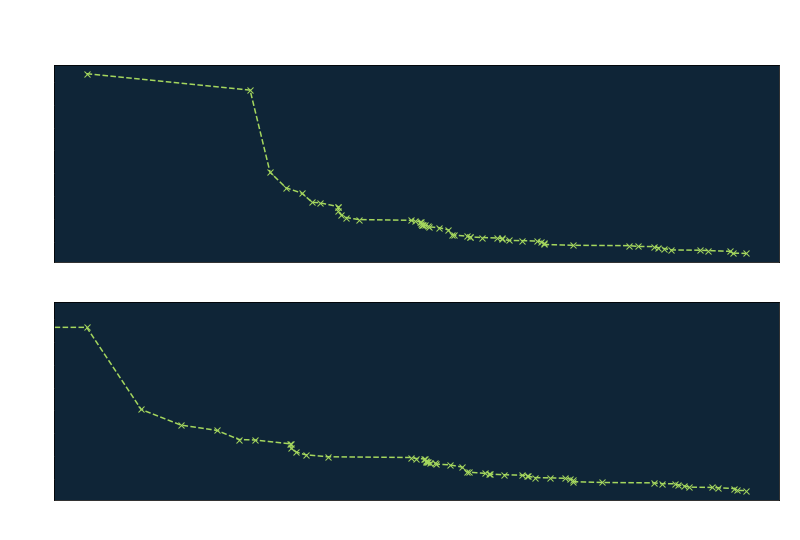

In [6]:
#| label: fig-super_mario_64
#| fig-cap: Speedrunning data for Super Mario 64 (120 Stars).


# Get the subset for a game
which_game = "Super Mario 64 - 120 Star - N64"
game_df = df[df["Game - Category"] == which_game]
game_df.head()

# Make the plot
fig, axs = plt.subplots(2,1, figsize=(13,8))

axs[0].plot(game_df["date"], game_df["time (seconds)"], "x--", color="#A5D75E")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Time (seconds)")

axs[1].plot(game_df["days since first run"], game_df["time (seconds)"], "x--", color="#A5D75E")
axs[1].set_xlabel("Days since first run (log-scale)")
axs[1].set_ylabel("Time (seconds)")
axs[1].set_xscale("log")

fig.suptitle(which_game)

plt.show()

# Here is some naiv

In [7]:
# Prepare leave-one-out train/test split
idx = df.groupby(['game', 'category'])['date'].idxmax()
df_test = df.loc[idx] # df_test includes the most recent WR of each category
assert len(df_test) == n_categories

mask = df.index.isin(idx)
df_train = df[~mask] # df_train contains the rest
assert len(df_train) + len(df_test) == n_runs

In [8]:
#@title Baseline prediction

predicted_quantity = 'time (seconds)' #@param ['time (seconds)', 'relative improvement']

import numpy as np

# As a baseline we will try predicting a time equal to 
# the last WR in the training set for each category
idx = df_train.groupby(['game', 'category'])['date (unix)'].idxmax()
df_pred = df_train.loc[idx]

# Match predictions
df_aux = df_test.merge(df_pred, how='inner', on=['game', 'category'], suffixes=('', ' predicted'))
df_aux = df_aux.drop(df_aux.columns.difference(['game', 'category', predicted_quantity, f'{predicted_quantity} predicted']), 1)

assert len(df_aux) == n_categories

# Compute error
y_pred = df_aux[f'{predicted_quantity} predicted']
y_test = df_aux[predicted_quantity]

error_dist = np.abs(y_pred.values - y_test.values)
error = error_dist.mean()
print(f"Baseline average absolute error is {error}")

relative_error_dist = (np.abs(y_pred.values - y_test.values) / y_test.values)
relative_error = relative_error_dist.mean()
print(f"Baseline average relative error is {relative_error}")

Baseline average absolute error is 18.714280000000016
Baseline average relative error is 0.00409371490943442


/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_21922/4121879648.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_aux = df_aux.drop(df_aux.columns.difference(['game', 'category', predicted_quantity, f'{predicted_quantity} predicted']), 1)


In [9]:
#@title Least squares model
import numpy as np
from sklearn.linear_model import LinearRegression

predictor = 'date (unix)' #@param ['date (unix)', 'WR index']
predicted_quantity = 'relative improvement' #@param ['time (seconds)', 'relative improvement']
data_formation = "punctual" #@param["punctual", "grid"]
grid_step = "WEEK" #@param["DAY", "WEEK", "MONTH"]
SECONDS_PER_DAY = 24*60*60
SECONDS_PER_WEEK = SECONDS_PER_DAY*7
SECONDS_PER_MONTH = SECONDS_PER_WEEK*4
if grid_step == "DAY":
  STEP = SECONDS_PER_DAY
elif grid_step == "WEEK":
  STEP = SECONDS_PER_WEEK
else:
  STEP = SECONDS_PER_MONTH
x_transform = "log" #@param ["identity", "inverse", "log"]
y_transform = "log" #@param ["identity", "log", "log log"]

func_dict = { # Transformations and inverses
    "identity" : (lambda x : x, lambda x : x),
    "inverse" : (lambda x : 1./x, lambda x : 1./x),
    "log" : (lambda x : np.log(x), lambda x : np.exp(x)),
    "log log" : (lambda x : np.log(np.log(x)), lambda x : np.exp(np.exp(x))),
}

x_transform, x_inv_transform = func_dict[x_transform]
y_transform, y_inv_transform = func_dict[y_transform]

assert np.abs(x_transform(x_inv_transform(100)) - 100) < 0.0001
assert np.abs(y_transform(y_inv_transform(100)) - 100) < 0.0001, np.abs(y_transform(y_inv_transform(100)) - 100)

entry_span = None #@param

pred_data = []
regs = {}
for (game_name, category_name), df_cat \
in tqdm(df_train.groupby(['game', 'category'])):
  # Filter last n entries to regress on
  if entry_span is not None:
    df_cat = df_cat.sort_values(by=predictor, ascending=True)
    df_cat = df_cat.iloc[-entry_span:]
    
  # Retrive data matrix
  if data_formation == 'punctual':
    x = df_cat[predictor].values
    y = df_cat[predicted_quantity].values
  elif data_formation == 'grid':
    # Generate a grid of observations, one per day
    
    x = np.arange(df_cat[predictor].min(), 
                  df_cat[predictor].max() + STEP - 1, 
                  STEP)
    df_cat.sort_values(by=predictor)
    wr_at_time = np.vectorize(
        lambda t : df_cat[df_cat[predictor] <= t]\
                   .iloc[-1][predicted_quantity]
        )
    y = wr_at_time(x)
  else: raise NotImplementedError()

  # Preprocess training data
  x = x_transform(x)
  x = x.reshape(-1,1)

  y = y_transform(y)
  
  # Fit linear regression
  reg = LinearRegression(normalize=True).fit(x, y)
  regs[(game_name, category_name)] = {'df': df_cat, 'reg':reg}

  # Predict next WR
  mask = (df_test['game'] == game_name) & (df_test['category'] == category_name)
  x = df_test[mask][predictor].values.reshape(-1, 1)
  x = x_transform(x)
  y = reg.predict(x)
  x = x_inv_transform(x)
  y = y_inv_transform(y)

  pred_data.append({'game' : game_name, 
                    'category' : category_name, 
                    predictor : x[0,0], 
                    f'{predicted_quantity} predicted' : y[0]})

df_pred = pd.DataFrame(pred_data)

assert len(df_pred) == n_categories
  
# Match predictions
df_aux = df_test.merge(df_pred, how='inner', on=['game', 'category'], suffixes=('', ' predicted'))
df_aux = df_aux.drop(df_aux.columns.difference(['game', 'category', predicted_quantity, f'{predicted_quantity} predicted']), 1)

assert len(df_aux) == n_categories

# Compute error
y_pred = df_aux[f'{predicted_quantity} predicted']
y_test = df_aux[predicted_quantity]

error_dist = np.abs(y_pred.values - y_test.values)
error = error_dist.mean()
print(f"Baseline average absolute error is {error}")

relative_error_dist = (np.abs(y_pred.values - y_test.values) / y_test.values)
relative_error = relative_error_dist.mean()
print(f"Baseline average relative error is {relative_error}")

# Plot category + regression

import altair as alt
alt.themes.enable('fivethirtyeight')

for (game_name, cat_name), df_cat in df_train.groupby(['game', 'category']): pass
data_chart = alt.Chart(df_cat).mark_point(size=120)\
.encode(
    x=alt.X(predictor),
    y=f'{predicted_quantity}:Q'
    )

x = np.linspace(df_cat[predictor].min(), df_test[mask][predictor].max())
x = x_transform(x)
x = np.nan_to_num(x)
y = reg.predict(x.reshape(-1, 1))
x = x_inv_transform(x)
y = y_inv_transform(y)

reg_df = pd.DataFrame({predictor:x, predicted_quantity:y})
reg_df['date'] = pd.to_datetime(reg_df[predictor],unit='s')
reg_chart = alt.Chart(reg_df).mark_line()\
.encode(
    x=alt.X(predictor),
    y=f'{predicted_quantity}:Q'
    )

(data_chart + reg_chart)\
.properties(
    title=f"Extrapolation for {game_name} - {cat_name}",
    width=800, 
    height=600,
    )\
.configure_axis(
    labelFontSize=20,
    titleFontSize=30
    )\
.interactive()

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html